# EDA

### Nichiho Skor (12334200)

Research question: Finding hard instances of the Aymmetric Traveling Salesman Problem

Private Github repository link: https://github.com/nichiho/Hardness-of-ATSP

This EDA includes the following:

1) The nl_cities dataset
- Clean the nl_cities dataset
- Visualize the nl_cities dataset
- Create possible TSP instances with the nl_cities dataset of with 10, 20, ..., 100 cities
- Run the Little's algorithm on the 10 TSP instances
- Determine an appropriate number of cities to use for future analyses

2) Implementation of the hill-climbing method
- Write code for the hill-climbing method for Little's algorithm
- Implement the hill-climbing method on some simple matrices
- Try to find some hard instances using the hill-climbing method

3) Literature
- A short summary of the papers read until now

# Imports

In [1]:
import pandas as pd
import numpy as np

import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import random

import sys
sys.path.insert(1, "..")

from LittlesAlgorithm.algorithm import get_minimal_route

## 1) The nl_cities dataset

# Load dataset

First, we load the nl_cities dataset.
The nl_cities dataset contians 944 rows (cities) and 9 columns.

The dataset is taken from https://simplemaps.com/data/nl-cities.

In [3]:
# Load nl_cities dataset

nl_cities = pd.read_csv('./nl_cities.csv')

print(nl_cities.head())
print(nl_cities.shape)

        city      lat     lng      country iso2     admin_name  capital  \
0  The Hague  52.0767  4.2986  Netherlands   NL   Zuid-Holland  primary   
1  Amsterdam  52.3667  4.8833  Netherlands   NL  Noord-Holland  primary   
2    Utrecht  52.0908  5.1222  Netherlands   NL        Utrecht    admin   
3  Rotterdam  51.9225  4.4792  Netherlands   NL   Zuid-Holland    minor   
4  Eindhoven  51.4408  5.4778  Netherlands   NL  Noord-Brabant    minor   

   population  population_proper  
0   1406000.0           501725.0  
1    862965.0           862965.0  
2    640000.0           316448.0  
3    631155.0           631155.0  
4    398053.0           209620.0  
(944, 9)


In [4]:
nl_cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 944 entries, 0 to 943
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   city               944 non-null    object 
 1   lat                944 non-null    float64
 2   lng                944 non-null    float64
 3   country            944 non-null    object 
 4   iso2               944 non-null    object 
 5   admin_name         941 non-null    object 
 6   capital            410 non-null    object 
 7   population         787 non-null    float64
 8   population_proper  787 non-null    float64
dtypes: float64(4), object(5)
memory usage: 66.5+ KB


# Clean dataset

## Null-values

The olumns 'admin_name', 'capital', 'population', 'population_proper' have some null-values (see above).

The column 'capital' has the most number of null-values.

We keep all the rows in the column but do not delete it since it is not a necessary column but can help later with choosing cities.

In [5]:
nl_cities[nl_cities["admin_name"].isna()]

,city,lat,lng,country,iso2,admin_name,capital,population,population_proper
673,Oranjestad,17.4833,-62.9833,Netherlands,NL,NaN,admin,1021.0,1021.0
749,The Bottom,17.6261,-63.2492,Netherlands,NL,NaN,admin,495.0,495.0
798,Kralendijk,12.1517,-68.2761,Netherlands,NL,NaN,admin,NaN,NaN


The column 'admin_name' only has three nan values.

Looking at the rows, all three are cities in the caribbean that belong to the Netherlands, so we delete them (They are connected by sea so we wouldn't be able to 'travel' there.)


In [6]:
# Drop 'admin_name' nan values

nl_cities.dropna(subset = ["admin_name"], inplace = True)

In [7]:
nl_cities.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 941 entries, 0 to 943
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   city               941 non-null    object 
 1   lat                941 non-null    float64
 2   lng                941 non-null    float64
 3   country            941 non-null    object 
 4   iso2               941 non-null    object 
 5   admin_name         941 non-null    object 
 6   capital            407 non-null    object 
 7   population         785 non-null    float64
 8   population_proper  785 non-null    float64
dtypes: float64(4), object(5)
memory usage: 73.5+ KB


The two columns 'population' and 'population_proper' have the same number of null-values.

We can delete those rows because if they are from the same row, we are still left with 785 rows (Two were common with admin_name).

In [8]:
# Drop 'population' and 'population_proper' nan values
nl_cities.dropna(subset = ["population", "population_proper"], inplace = True)

# After deleting them, we are left with 785 rows so they are from the same rows.

nl_cities.shape

(785, 9)

## Columns to delete

Column 'country' and 'iso2' are not necessary, as all cities are Dutch.

The rest we keep for the reasons above.

In [9]:
# Delete the 'country' and 'iso2' columns

nl_cities.drop(columns = ["country", "iso2"], axis = 1, inplace = True)

## Distribution of cities

We make a map of the cities included in the dataframe with their columns to see patterns/distributions.

We do this using geopandas.

In [10]:
# Load NL map divided per province.
mapnl = gpd.read_file("https://stacks.stanford.edu/file/druid:st293bj4601/data.zip")

mapnl = mapnl[["NAME_1", "TYPE_1", "geometry"]]

print(mapnl.head(1))

    NAME_1     TYPE_1                                           geometry
0  Drenthe  Provincie  POLYGON ((6.50131 53.19841, 6.50429 53.19749, ...


In [11]:
# Create geometry coordinates from 'lng' and 'lat' columns from nl_cities

crs = {'init':'EPSG:4326'}
geometry = [Point(xy) for xy in zip(nl_cities['lng'], nl_cities['lat'])]
geo_nl_cities = gpd.GeoDataFrame(nl_cities.copy(), 
                          crs = crs,
                          geometry = geometry)

print(geo_nl_cities.head(1))

        city      lat     lng    admin_name  capital  population  \
0  The Hague  52.0767  4.2986  Zuid-Holland  primary   1406000.0   

   population_proper                  geometry  
0           501725.0  POINT (4.29860 52.07670)  


/home/nskor/Hardness-of-ATSP/.venv/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Plot cities on the map.

Each marker's color and size shows population_proper


/home/nskor/Hardness-of-ATSP/.venv/lib/python3.10/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


Text(0.5, 1.0, 'Cities in the Netherlands population heatmap')

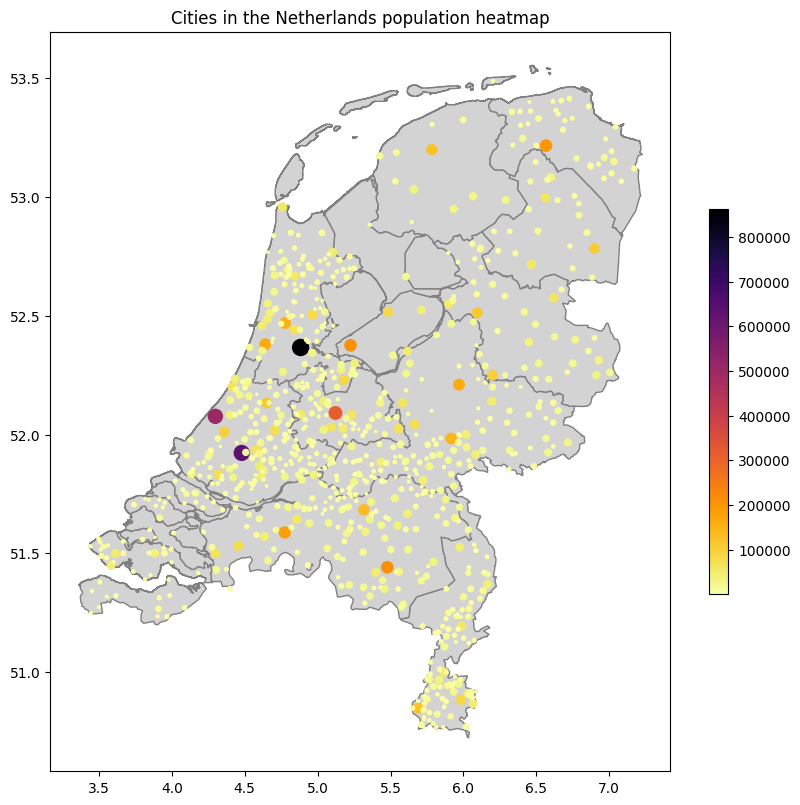

In [12]:
# Create figure
fig, ax = plt.subplots(figsize = (10, 10))

# Plot map of the Netherlands
mapnl.plot(column = "NAME_1", edgecolor="grey", ax = ax, color = 'lightgrey')

# Create marker_size which will represent the population_proper of each city by marker size
geo_nl_cities['marker_size'] = np.sqrt(geo_nl_cities['population_proper']) / 7

# Plot map of Dutch cities by their population_proper
geo_nl_cities.plot(column = 'population_proper', cmap = "inferno_r", ax = ax, legend = True, legend_kwds={'shrink': 0.5}, 
            markersize = 'marker_size')

ax.set_title('Cities in the Netherlands population heatmap')

# Determine the number of cities to use to run Little's algorithm

## Create instances

Create instances of 10, 20, 30, ..., 100 biggest Dutch cities by population.

We do this to decide how big our matrices should be for further investigation.


In [13]:
# Dictionary that includes dataframe of each city and its geometry for each instance
instances = {}

# For loop to create 10 instances
for i in range(10, 110, 10):
    
    # Pick top i city by population_proper
    instances[i] = geo_nl_cities.sort_values(['population_proper'], ascending = False).head(i)[["city", "geometry"]]
    
    instances[i].set_index("city", drop = True, inplace = True)
    
instances[10]

,geometry
city,
Amsterdam,POINT (4.88330 52.36670)
Rotterdam,POINT (4.47920 51.92250)
The Hague,POINT (4.29860 52.07670)
Utrecht,POINT (5.12220 52.09080)
Eindhoven,POINT (5.47780 51.44080)
Almere,POINT (5.22560 52.37580)
Groningen,POINT (6.56670 53.21670)
Breda,POINT (4.77500 51.58750)
Apeldoorn,POINT (5.97000 52.21000)


## Create distance matrix

For now we solve the symmetric traveling salesman problem with distances between cities; in the future, we find another dataset to implement the asymmetric one, which will be very similar to this case.

In the future make more than 1 instance for each of them

In [14]:
# Dictionary of distance matrices for each instance as a pandas DataFrame (includes the city names)
instance_matrix = {}

# Dictionary of dictionary matrices for each instance as a numpy array (does not include the city names)
instance_np_matrix = {}

for i in range(10, 110, 10):
    # Create diagonal matrix
    instance_matrix[i] = pd.DataFrame(np.diag(instances[i]["geometry"]), columns=instances[i].index, index=instances[i].index)
    
    # Add distance between each city
    # For simplicity, make them all 2 decimal places
    for city1 in instance_matrix[i].index:
        for city2 in instance_matrix[i].index:
            if city1 != city2:
                instance_matrix[i][city1][city2] = round(instances[i]["geometry"][city1].distance(instances[i]["geometry"][city2]), 2)
    
    # Set the diagonal (same city) to inf
    for city1, city2 in zip(instance_matrix[i].index, instance_matrix[i].index):
        instance_matrix[i][city1][city2] = np.inf
    
    # Create numpy array from DataFrame to input into Little's algorithm function later
    instance_np_matrix[i] = instance_matrix[i].to_numpy().astype(float)

In [15]:
instance_matrix[10]

city,Amsterdam,Rotterdam,The Hague,Utrecht,Eindhoven,Almere,Groningen,Breda,Apeldoorn,Haarlem
city,,,,,,,,,,
Amsterdam,inf,0.6,0.65,0.36,1.1,0.34,1.89,0.79,1.1,0.24
Rotterdam,0.6,inf,0.24,0.66,1.11,0.87,2.46,0.45,1.52,0.49
The Hague,0.65,0.24,inf,0.82,1.34,0.97,2.54,0.68,1.68,0.46
Utrecht,0.36,0.66,0.82,inf,0.74,0.3,1.83,0.61,0.86,0.56
Eindhoven,1.1,1.11,1.34,0.74,inf,0.97,2.08,0.72,0.91,1.26
Almere,0.34,0.87,0.97,0.3,0.97,inf,1.58,0.91,0.76,0.59
Groningen,1.89,2.46,2.54,1.83,2.08,1.58,inf,2.42,1.17,2.1
Breda,0.79,0.45,0.68,0.61,0.72,0.91,2.42,inf,1.35,0.8
Apeldoorn,1.1,1.52,1.68,0.86,0.91,0.76,1.17,1.35,inf,1.34


In [16]:
instance_np_matrix[10]

array([[ inf, 0.6 , 0.65, 0.36, 1.1 , 0.34, 1.89, 0.79, 1.1 , 0.24],
       [0.6 ,  inf, 0.24, 0.66, 1.11, 0.87, 2.46, 0.45, 1.52, 0.49],
       [0.65, 0.24,  inf, 0.82, 1.34, 0.97, 2.54, 0.68, 1.68, 0.46],
       [0.36, 0.66, 0.82,  inf, 0.74, 0.3 , 1.83, 0.61, 0.86, 0.56],
       [1.1 , 1.11, 1.34, 0.74,  inf, 0.97, 2.08, 0.72, 0.91, 1.26],
       [0.34, 0.87, 0.97, 0.3 , 0.97,  inf, 1.58, 0.91, 0.76, 0.59],
       [1.89, 2.46, 2.54, 1.83, 2.08, 1.58,  inf, 2.42, 1.17, 2.1 ],
       [0.79, 0.45, 0.68, 0.61, 0.72, 0.91, 2.42,  inf, 1.35, 0.8 ],
       [1.1 , 1.52, 1.68, 0.86, 0.91, 0.76, 1.17, 1.35,  inf, 1.34],
       [0.24, 0.49, 0.46, 0.56, 1.26, 0.59, 2.1 , 0.8 , 1.34,  inf]])

## Implement Little's algorithm on the 10 matrices

We check the run-time of the algorithm.

We are running this on a super-computer, if the kernel dies even with the super-computer, we know the number of cities chosen is too large/

In [20]:
# Dictionary that includes number of iterations it took to find a solution for each instance
iterations = {}

# Dictionary that includes optimal route solution for each instance
optimal_route = {}

# Dictinoary that includes the runtime to find the optimal solution
optimal_cost = {}

try:
    for i in range(10, 110, 10):
        
        # Use get_minimal_route function from LittlesAlgorithm/algorithm.py
        iterations[i], optimal_route[i], optimal_cost[i] = get_minimal_route(instance_np_matrix[i])
        
        print("The algorithm found a solution after ", iterations[i], " iterations and ", optimal_cost[i], " seconds for ", i, "cities.")

except KeyboardInterrupt:
    pass

The algorithm found a solution after  20  iterations and  6.43  seconds for  10 cities.
The algorithm found a solution after  710  iterations and  8.82  seconds for  20 cities.
The algorithm found a solution after  3701  iterations and  10.300000000000002  seconds for  30 cities.


: 

: 

The kernel dies when it is trying to run with 40 cities, but for 30 cities, the algorithm runs pretty fast.
So for now 30 cities seems to be ideal.

We do see though that the number of iterations increases very fast (exponential).

We can investigate this further in the future by making more instances (maybe 10 of each) - this particular instance might have just been a very hard instance.

In [9]:
# To-do

# Find asymmetric TSP datasets - e.g. road distances, road time taken - look into Google Maps API.

# 2) Implementation of the hill-climbing method

The hill-climbing method works as follows:

1. Make a random matrix
2. Calculate the shortest tour & measure and save the run-tume of Little's algorithm
3. Mutate the matrix (change a single number)
4. Calculate the shortest tour & measure the run-time of Little's algorithm
5. (a) If the new run time > old run time, go to #3
<br>
(b) If the new run time <= old run time, revert to the older matrix, then go to #3

The Little's algorithm source code is taken from http://heuristieken.nl/wiki/index.php?title=Where_the_Really_Hard_Problems_Aren%27t

## Function mutate_matrix

Function: mutates an n x n matrix

Inputs:
- matrix: an n x n matrix of any size
- n_cities: matrix size of each n
- max_value: the maximum value that an element in matrix can have

Outputs: matrix, but with one element (not in the diagonal) replaced with a value between 1 and max_value

In [2]:
def mutate_matrix(matrix, n_cities, max_value):
    
    matrix_new = matrix.copy()
    # For the future: mutation can be done by modifying: adding by a value, by a certain percentage, etc.
        # Disadvantage: If we start with small numbers, the values will stay small for a long time
        # Replacing by a random value: no bias
    # Not doing that for now because replacing by a random value shouldn't change the output by much at the moment

    # Draw a sample of two numbers, random.sample makes sure the two numbers are not equal
    [x, y] = random.sample(range(0, n_cities), 2)
    
    # Matrice elements are random number between 1 and max_value
    matrix_new[x][y] = random.randint(1, max_value)
    
    return matrix_new

## Function hill_climbing

Function: Implements the hill-climbing approach for the Little's algorithm

Inputs: 
- n_cities: the number of cities that the matrix created should have (matrix will be of size n_cities x n_cities)
- max_value: the maximum value that an element in the matrix can have
- n_iterations: the number of times to hill-climb

Outputs:
- mtx_list: A list of all the matrices created
- run_time_list: A list of the number of iterations of Little's algorithm for each of the matrices in mtx_list
- used_or_not: A list of Booleans for whether each matrix in mtx_list was used for the next iteration or not

In [3]:
def hill_climbing(n_cities, max_value, n_iterations):
    
    # A list of all the matrices
    mtx_list = []
    
    # A list of the performance for each matrix
    performance_list = []
    
    # A list of whether each matrix in mtx_list is used or not
    used_or_not = []
    
    # 1. Make a random matrix
    
    # Matrice elements to be a random number between 1 and max_value
    # (Same as Zhang & Khorfs a study of the complexity transitions on the ATSP)
    mtx_1 = np.random.randint(1, max_value, size = (n_cities, n_cities)).astype(float)
    np.fill_diagonal(mtx_1, np.inf)
    mtx_list.append(mtx_1)
    used_or_not.append(True)
    
    #2. Calculate the shortest tour & measure and save the performance of Little's algorithm
    performance_1 = get_minimal_route(mtx_1)[0]
    performance_list.append(performance_1)
    
    try:
        for i in range(0, n_iterations):
            print(i)

            # 3. Mutate the matrix (change a single number)
            mtx_2 = mutate_matrix(mtx_1, n_cities, max_value)
            mtx_list.append(mtx_2)
            
            # 4. Calculate the shortest tour & measure the performance of Little's algorithm
            performance_2 = get_minimal_route(mtx_2)[0]
            performance_list.append(performance_2)
            
            # 5. 
            # (a) If the new performance > old performance, go to #3
            if performance_2  > performance_1:
                # new matrix becomes mtx_1, mutate from that
                mtx_1 = mtx_2.copy()
                performance_1 = performance_2
                used_or_not.append(True)
            
            # (b) If the new performance <= old performance, revert to the older matrix, then go to #3
            if performance_2 <= performance_1:
                # Don't need to do anything, just repeat with mtx_1
                used_or_not.append(False)
        
    except KeyboardInterrupt:
        pass
    
    return mtx_list, performance_list, used_or_not

## Implement the hill-climbing approach

We determined in the previous section that 30 cities could be an appropriate number of cities to use.

We implement hill-climbing with 30 cities, with elements of maximum value 10, and 100 iterations.

In [4]:
mtx_list, performance_list, used_or_not = hill_climbing(30, 10000, 200)

print(mtx_list, performance_list, used_or_not)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
[array([[  inf,  872., 7634., 7793., 2216., 1296., 2389., 1971., 4605.,
        7015., 3822., 7559., 6219., 1055., 9344., 8176., 4872., 1743.,
        6656., 9890., 5030., 9563., 5758., 4038.,   91., 2361., 5178.,
        3018., 3219., 9970.],
       [6756.,   inf, 4049., 3077., 2346., 8940., 5862., 9658., 54

Plot the performance of the algorithm

We see the number of iterations slowly go up. 

Everytime the algorithm finds a hard problem, it takes a while before finding another hard one, but manages to at some point.

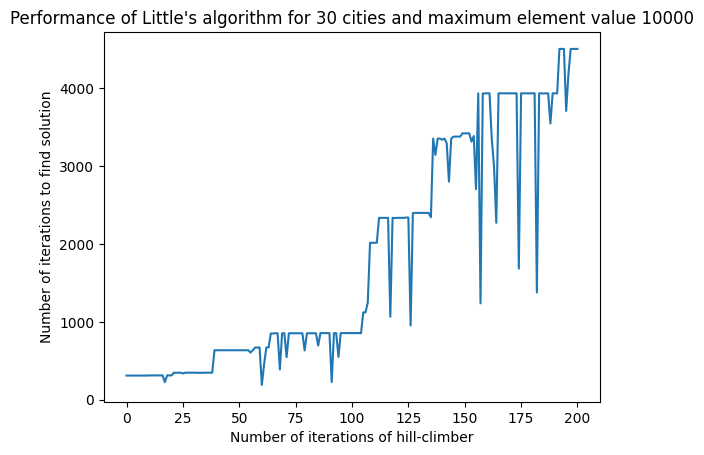

In [6]:
plt.plot(performance_list)
plt.title("Performance of Little's algorithm for 30 cities and maximum element value 10000")
plt.xlabel("Number of iterations of hill-climber")
plt.ylabel("Number of iterations to find solution")
plt.show()

3) A short summary of literature

Cheeseman et al "Where the Really Hard Problems Are"
- Uses Little's algorithm
- Matrices constructed according to a lognormal distribution
- Standard deviation affects the hardness of a problem: Hard when standard deviation is very high or very low.
- TSP

Sleegers et al "Where the Really Hard Problems Area"
- Replication study of "Where the Really Hard Problems Are"
- Debunked their theory about standard deviation
- ATSP

Koppenhol et al "Exactly characterizable parameter settings in a crossoverless evolutionary algorithm"
- Plant Propagation Algorithm (PPA) is consistent with TSP, but insensitive to different problem instances (Different results from previous research)
- PPA could potentially outperform other algorithms on a cost-benefit basis
- Little's algorithm


Geleijn et al "The Plant Propagation Algorithm on Timetables: First Results"
- One stochastic hillclimber and two plant propagation algorithms (PPA-1, PPA-2) on University Course Timetabling Problem from UvA
- PPA-1 outperforms HillClimber, PPA-2 makes the best timetables
- TSP

Sleegers, van den Berg "Looking for the Hardest Hamiltonian Cycle Problem Istances"
- Hamiltonian cycle problem, Vandegriend-Culberson algorithm
- Hillclimber & PPA similar results
- Hardest instances: all non-Hamiltonian - high degree of regularity and scalability across graph sizes
- Hamitlonian-bound hard instances less uniform and substantially easier than their non-Hamiltonian counterparts

Sleegers, van den Berg "Plant Propagation & Hard Hamiltonian Graphs"
- Hamiltonian cycle problem
- Hillclimber & PPA both ind hard graphs in all size categories
- In most ensembles, more than half of the evolutionary runs generates graphs requiring over 10000 recursions, sometimes even ranging in the millions.
- Hillclimber outperforms PPA in finding hard graphs (but PPA might outperform in the longer-run)

Little et al "An Algorithm for the Traveling Salesman Problem"
- Little's algorithm: Branch and Bound (BnB) algorithm for solving TSP

Zhang & Korf "A study of complexity transitions on the asymmetric traveling salesman problem"
- Complexity of BnB algorithms experience an easy-hard transition when intercity distances (drawn uniformly from 0, 1, 2, ..., r) inreases.
- Easy-hard complexity transitions for ATSP from log-normal distribution
- Control parameter number of distinct intercity distances determines complexity
- Easy-hard transitions are not as sharp as predicted by analytical results, probably due to the fact that the independence assumptions in the analysis are not valid in real problems.

van den Berg "When is an AP-solution also an ATSP-solution?"
- Assignment problem (AP) very close to ATSP; some solutions are for both
- AP solvable in polynomial time, ATSP probably not (don't know yet)
- Replication study Zhang & Korf, result comparable except for the initial segment
- For 100x100 matrices, approximately 2.017% of AP solutions are also ATSP solutions when randMax >= 20, but results depend on numerical entries inside the matrix (non-conclusive)